# Scraping Louisiana Tech faculty homepages

## Faculty Directory Page: https://coes.latech.edu/facultystaff-directory/

This page contains 274 faculty individual profiles.

In [26]:
from bs4 import BeautifulSoup
from selenium import webdriver 
from selenium.webdriver.chrome.options import Options
import re 
import urllib

In [27]:
#create a webdriver object and set options for headless browsing
options = Options()
options.headless = True
browser = webdriver.Chrome('./chromedriver',options=options)

If you visit Louisiana Tech Faculty Directory Listing: https://coes.latech.edu/facultystaff-directory/ , you'll notice that it has all the faculty listed there. 
Clicking on a named link takes you to the Faculty Profile page. 
The profile page has more info about the faculty and sometimes contains the faculty hompage url under the Overview Tab > For More Information which is ultimately what we want to scrape.

Before we start scraping, we'll define some helper functions

In [28]:
#uses webdriver object to execute javascript code and get dynamically loaded webcontent
def get_js_soup(url,browser):
    browser.get(url)
    res_html = browser.execute_script('return document.body.innerHTML')
    soup = BeautifulSoup(res_html,'html.parser') #beautiful soup object to be used for parsing html content
    return soup

#tidies extracted text 
def process_bio(bio):
    bio = bio.encode('ascii',errors='ignore').decode('utf-8')       #removes non-ascii characters
    bio = re.sub('\s+',' ',bio)       #repalces repeated whitespace characters with single space
    return bio

''' More tidying
Sometimes the text extracted HTML webpage may contain javascript code and some style elements. 
This function removes script and style tags from HTML so that extracted text does not contain them.
'''
def remove_script(soup):
    for script in soup(["script", "style"]):
        script.decompose()
    return soup


#Checks if bio_url is a valid faculty homepage
def is_valid_homepage(bio_url,dir_url):
    try:
        #sometimes the homepage url points to the faculty profile page
        #which should be treated differently from an actual homepage
        ret_url = urllib.request.urlopen(bio_url).geturl() 
    except:
        return False       #unable to access bio_url
    urls = [re.sub('((https?://)|(www.))','',url) for url in [ret_url,dir_url]] #removes url scheme (https,http) or www 
    return not(urls[0]== urls[1])

We will now start scraping.

<!--
<div class="cn-list-section-head" id="cn-char-A"></div><div class="cn-list-row-alternate vcard individual administrative-and-technical-staff civil-engineering college-of-engineering-and-science construction-engineering-technology mechanical-engineering" id="sue-antony" data-entry-type="individual" data-entry-id="736" data-entry-slug="sue-antony"><div class="cn-entry">
	<div class="listing-left">
		<p><a href="https://coes.latech.edu/facultystaff-directory/single-entry/name/sue-antony/" title="Sue Antony">Sue Antony</a></p>
		<p><span class="title notranslate">Administrative Coordinator 3</span>
</p>
		<p class="department"><strong>Departments: </strong>Administrative and Technical Staff, Civil Engineering, Construction Engineering Technology, Mechanical Engineering	</div>
	<div class="listing-right">
		<p><strong>Office: </strong>BOGH 257<p><p><strong>Phone: </strong>318-257-2357<p><p><strong>Fax: </strong>318-257-4630<p><p><strong>Email: </strong><a href="mailto:santony@latech.edu">santony@latech.edu</a><p>	</div>
</div>
-->

Now we can specify exactly what needs to be extracted from the directory listing page

In [29]:
#extracts all Faculty Profile page urls from the Directory Listing Page
def scrape_dir_page(dir_url,browser):
    print ('-'*20,'Scraping directory page','-'*20)
    faculty_links = []
    faculty_base_url = 'https://coes.latech.edu'
    #execute js on webpage to load faculty listings on webpage and get ready to parse the loaded HTML 
    soup = get_js_soup(dir_url,browser)     
    for link_holder in soup.find_all('div',class_='listing-left'): #get list of all <div> of class 'photo nocaption'
        #rel_link = link_holder.find('a')['href'] #get url
        #url returned is relative, so we need to add base url
        #faculty_links.append(faculty_base_url+rel_link) 
        faculty_links.append(link_holder.find('a')['href'])
    print ('-'*20,'Found {} faculty profile urls'.format(len(faculty_links)),'-'*20)
    return faculty_links

In [30]:
dir_url = 'https://coes.latech.edu/facultystaff-directory/' #url of directory listings of CS faculty
faculty_links = scrape_dir_page(dir_url,browser)

('--------------------', 'Scraping directory page', '--------------------')
('--------------------', 'Found 274 faculty profile urls', '--------------------')


Now let's scrape the Faculty Profile pages to find faculty homepage urls. 

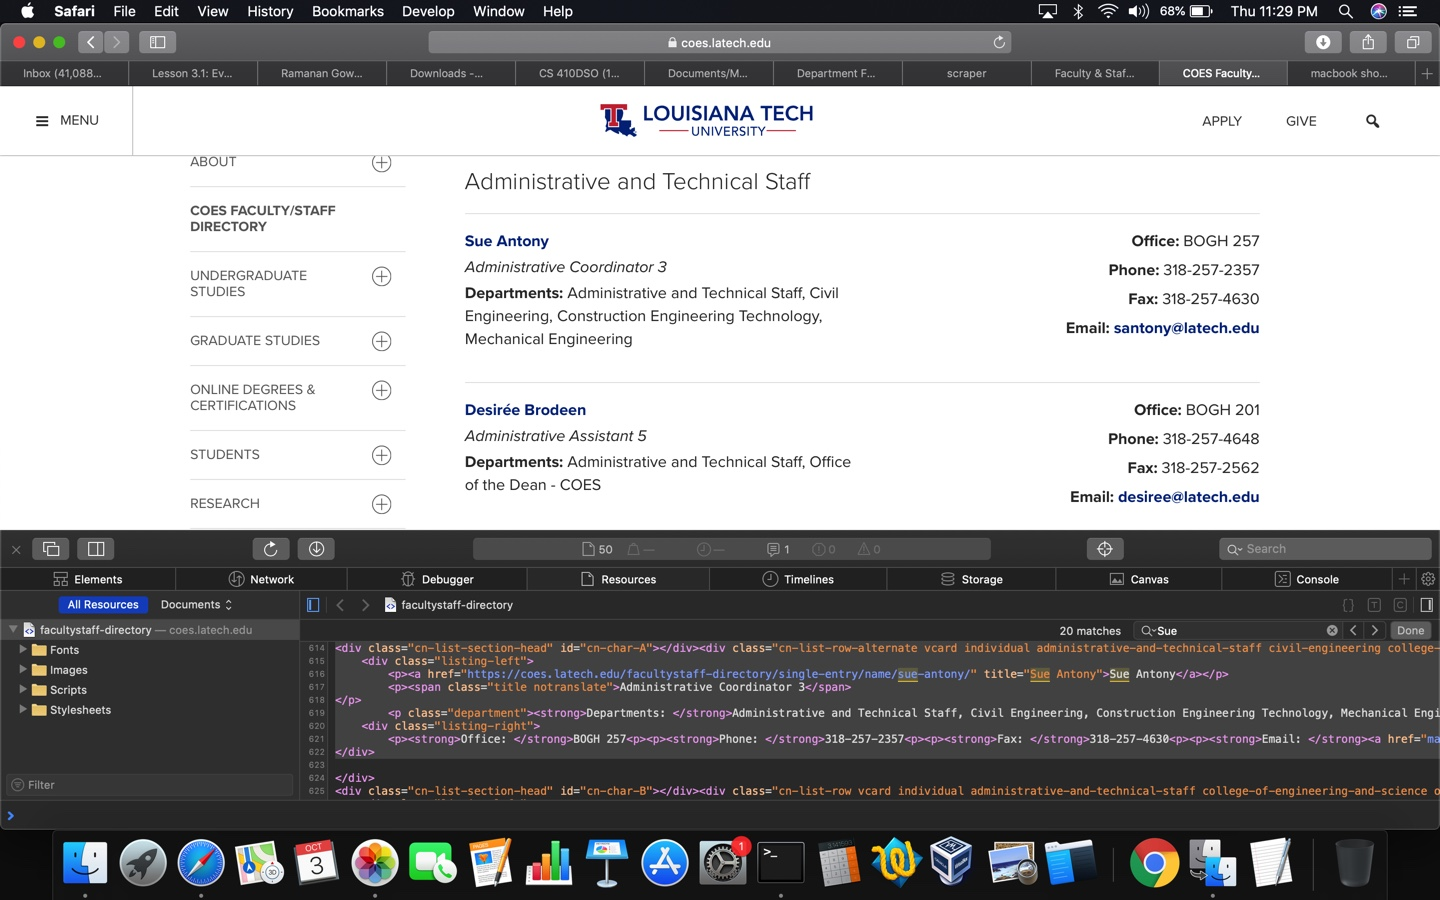


In [31]:
def scrape_faculty_page(fac_url,browser):

    soup = get_js_soup(fac_url,browser)
    homepage_found = False
    bio_url = ''
    bio = ''
    """
    #find overview tab
    try:
        overview_tab = soup.find('div',id='overview')
    except:
        print (soup)
    #define patterns for the anchor text of homepage url
    faculty_last_name = soup.find('div',class_='extName').find_next().get_text().lower().split()[-1] #find faculty name
    homepage_txts = ['site','page',' '+faculty_last_name]
    exceptions = ['course ','research','group','cs','mirror','google scholar']
    #find the homepage url and extract all text from it
    for hdr in overview_tab.find_all('h2'):  #first find the required header
        if hdr.text.lower() == 'for more information':
            next_tag = hdr.find_next('li')
            #find <li> which has homepage url
            while next_tag is not None: 
                cand = next_tag.find('a')
                next_tag = next_tag.next_sibling    #sibling means element present at the same level
                cand_text = cand.get_text().lower()
                if (any(hp_txt in cand_text for hp_txt in homepage_txts) and 
                    not any(e in cand_text for e in exceptions)): #compare text to predefined patterns
                    bio_url = cand['href'] 
                    homepage_found = True
                    #check if homepage url is valid
                    if not(is_valid_homepage(bio_url,fac_url)): 
                        homepage_found = False
                    else:
                        try:
                            bio_soup = remove_script(get_js_soup(bio_url,browser)) 
                        except:
                            print ('Could not access {}'.format(bio_url))
                            homepage_found = False
                    break 
            if homepage_found:
                #get all the text from homepage(bio) since there's no easy to filter noise like navigation bar etc
                bio = process_bio(bio_soup.get_text(separator=' ')) 
    """
    if not homepage_found:
        bio_url = fac_url #treat faculty profile page as homepage
        #we're only interested in some parts of the profile page namely the address
        #and information listed under the Overview, Research, Publication and Awards tab
        bio = soup.find('div',class_='listing-left').get_text(separator=' - ')+': '
        bio += soup.find('div',class_='listing-right').get_text(separator=' ')
        #for tab in soup.find_all('div',class_='tab-pane'):
        #    bio += tab.get_text(separator=' ')+'. '
        bio = process_bio(bio)

    return bio_url,bio

In [32]:
#Scrape all faculty homepages using profile page urls
bio_urls, bios = [],[]
tot_urls = len(faculty_links)
for i,link in enumerate(faculty_links):
    print ('-'*20,'Scraping faculty url {}/{}'.format(i+1,tot_urls),'-'*20)
    bio_url,bio = scrape_faculty_page(link,browser)
    bio_urls.append(bio_url)
    bios.append(bio)

('--------------------', 'Scraping faculty url 1/274', '--------------------')
('--------------------', 'Scraping faculty url 2/274', '--------------------')
('--------------------', 'Scraping faculty url 3/274', '--------------------')
('--------------------', 'Scraping faculty url 4/274', '--------------------')
('--------------------', 'Scraping faculty url 5/274', '--------------------')
('--------------------', 'Scraping faculty url 6/274', '--------------------')
('--------------------', 'Scraping faculty url 7/274', '--------------------')
('--------------------', 'Scraping faculty url 8/274', '--------------------')
('--------------------', 'Scraping faculty url 9/274', '--------------------')
('--------------------', 'Scraping faculty url 10/274', '--------------------')
('--------------------', 'Scraping faculty url 11/274', '--------------------')
('--------------------', 'Scraping faculty url 12/274', '--------------------')
('--------------------', 'Scraping faculty url 13

('--------------------', 'Scraping faculty url 104/274', '--------------------')
('--------------------', 'Scraping faculty url 105/274', '--------------------')
('--------------------', 'Scraping faculty url 106/274', '--------------------')
('--------------------', 'Scraping faculty url 107/274', '--------------------')
('--------------------', 'Scraping faculty url 108/274', '--------------------')
('--------------------', 'Scraping faculty url 109/274', '--------------------')
('--------------------', 'Scraping faculty url 110/274', '--------------------')
('--------------------', 'Scraping faculty url 111/274', '--------------------')
('--------------------', 'Scraping faculty url 112/274', '--------------------')
('--------------------', 'Scraping faculty url 113/274', '--------------------')
('--------------------', 'Scraping faculty url 114/274', '--------------------')
('--------------------', 'Scraping faculty url 115/274', '--------------------')
('--------------------', 'Sc

('--------------------', 'Scraping faculty url 206/274', '--------------------')
('--------------------', 'Scraping faculty url 207/274', '--------------------')
('--------------------', 'Scraping faculty url 208/274', '--------------------')
('--------------------', 'Scraping faculty url 209/274', '--------------------')
('--------------------', 'Scraping faculty url 210/274', '--------------------')
('--------------------', 'Scraping faculty url 211/274', '--------------------')
('--------------------', 'Scraping faculty url 212/274', '--------------------')
('--------------------', 'Scraping faculty url 213/274', '--------------------')
('--------------------', 'Scraping faculty url 214/274', '--------------------')
('--------------------', 'Scraping faculty url 215/274', '--------------------')
('--------------------', 'Scraping faculty url 216/274', '--------------------')
('--------------------', 'Scraping faculty url 217/274', '--------------------')
('--------------------', 'Sc

Finally, write urls and extracted bio to txt files

In [33]:
def write_lst(lst,file_):
    with open(file_,'w') as f:
        for l in lst:
            f.write(l)
            f.write('\n')

In [34]:
bio_urls_file = '../bio_urls.txt'
bios_file = '../bios.txt'
write_lst(bio_urls,bio_urls_file)
write_lst(bios,bios_file)